# Installing required libraries into our virtual machine

In our case we require the following libaries:

*   `Keras` to deal with CNN models
*   `PyDrive` to connect with Google Drive
*   `roby` to perform Robustness Analysis



In [ ]:
!pip install -q keras

In [ ]:
!pip install -U -q PyDrive

In [ ]:
!pip install -q --index-url https://test.pypi.org/simple/ roby

# Removing the previous temporary files

In [ ]:
!rm -r /content/*

#Importing the required libraries

In [ ]:
from google.colab import files
from roby.CloudTools import authenticate
from roby.CloudTools import upload_config
from roby.CloudTools import process_config
from roby.RobustnessCNN import classification
from roby.RobustnessCNN import robustness_test
from roby.RobustnessCNN import display_robustness_results
from roby.Alterations import GaussianNoise
from imutils import paths
import imutils
import cv2
from keras.preprocessing.image import img_to_array
import numpy as np

#Mounting Google Drive in our VM

This step allows the user to authorize Google Colab to access its own Google Drive. The user will be required to click a link, authorize the connection, and paste in a text-box the given Key

In [ ]:
drive = authenticate()


# Defining the `pre-processing` and `post-processing` functions

These two functions are not mandatory, but sometimes they are required to fit the images to those on which the model has been trained.


*   The `pre-processing` function adapts the images before their classification or the application of alterations
*   The `post-processing` function can be used to scale the probability given as output by the CNN

In our case, we have to define the `pre-processing` function but not the `post-processing` one.

In [ ]:
def pre_processing(image):
    # Pre-process the image for classification, in the same way of the pictures used for the training of the CNN
    output = imutils.resize(image, width=50)
    image = cv2.resize(image, (50, 50))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# Defining the `labeler` function
This function receives as input the name of the file and builds the correct classification

In [ ]:
def labeler(image):
    real_label = (image.split('.')[0]).split('_')[-1]
    return real_label

# Setting-up the environment
In this step we set up the environment. The links to the `model`, `classes` file, `dataset` and the `labels` are given as a string to the `process_config` method. An alternative is to use the method `processConfigFromXML` which receives the root of an XML configuration file as parameter.

In this case we have used a method (`process_config`) that sets-up the environment. It is possible, otherwhise, to use the constructor of the `EnvironmentRTest` and to retrieve the model, the classes and the dataset using three separate functions (`load_classes_from_url(classes_link, drive)`, `load_dataset_from_url(link_dataset_dir, drive)`, `load_model_from_url(model_link, drive)` amd `load_labels_from_url(label_list_link, drive)`). Having retrieved the three components, one can use `EnvironmentRTest(model, file_list, classes, label_list, labeler_function, pre_processing_function, post_processing_function)` to get the correct environment.



In [ ]:
model_link = "https://drive.google.com/file/d/1LHdKagAn4eAcTx1DJvacwkGdtYYzubwX"
link_dataset_dir = "https://drive.google.com/drive/folders/1IKZkcRcyZhkcfoABuJQciChMPwm9B4-_"
classes_link = "https://drive.google.com/file/d/1V56GoKs-sNZVYCraJM9dfsgAYl6-UJyu"
accuracy_threshold = 0.8
environment = process_config(model_link, link_dataset_dir, classes_link, drive, labeler_f = labeler, preProcessingFunction = pre_processing)

Model Uploaded
Uploading Dataset...
Dataset Uploaded
Classes Uploaded


# Computing the accuracy of the network with un-altered images
During this step we check the accuracy of the network, using un-altered pictures

In [ ]:
accuracy = classification(environment)

Successes: 183
Failures: 31
Accuracy: 0.8551401869158879


#Computing the robustness using GaussianNoise as Alteration
After having all the information loaded, we can define the alteration we want to test the network with. 
In this case we define `GaussianNoise(0,1,200)` as alteration, where:


*   `0` is the minimum alteration value that corresponds, in the case of GaussianNoise, to a Gaussian Noise with zero-mean and zero-variance.
*   `1` is the mavimum alteration value that corresponds, in the case of GaussianNoise, to a Gaussian Noise with zero-mean and 200 as variance.
*   `200` is the variance of the noise.


In [ ]:
# create the alterationType as a GaussianNoise, from 0 to 1
alterationType = GaussianNoise(0, 1, 200)

After alteration definition, we can perform robustness analysis, on a given `environment`, for a certain `alterationType` and computing `20` alteration values within the alteration range

In [ ]:
# perform robustness analysis
results = robustness_test(environment, alterationType, 20, accuracy_threshold)

Robustness: 0.075


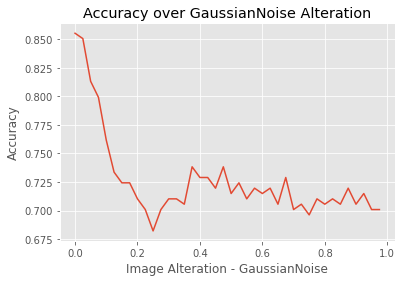

In [ ]:
# show the final result and the plot
display_robustness_results(results)